=== Demo: single dataset fit (with stars selection) ===

new_synthesis:
  pi      =  0.300
  kappa   =  0.600
  beta    =  0.942
  gamma1  =  0.656
  gamma0  =  0.534
  loglik = 393.99

vh_like:
  pi      =  0.750
  kappa   =  0.600
  jump    =  1.245
  stars   =  0.503
  loglik = 383.07

Bootstrap 80% intervals (nonparametric):
  New synthesis  : {'pi': (0.05, 0.6), 'beta': (0.695, 1.247), 'gamma1': (0.433, 0.96), 'gamma0': (0.335, 0.822)}
  VH-like        : {'pi': (0.45, 0.9), 'jump': (1.017, 1.554), 'stars': (0.29, 0.738)}


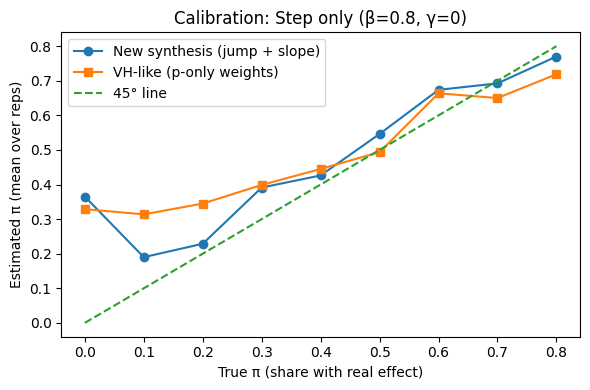

MAE — step only:
  New synthesis: 0.08430555555555556
  VH-like     : 0.1147222222222222


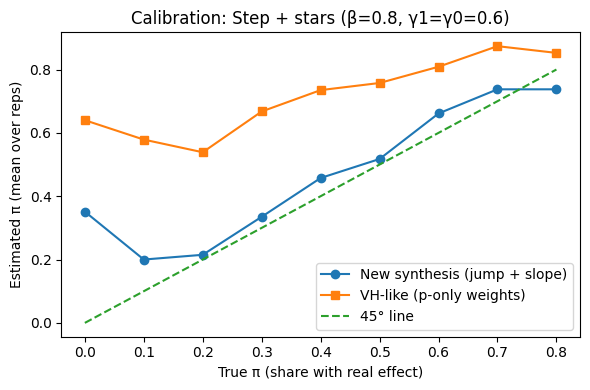

MAE — step + stars:
  New synthesis: 0.08194444444444446
  VH-like     : 0.3169444444444445

Ready. Use `analyze_pvalues(your_p_array)` to fit both models on your data.


In [1]:
# New-synthesis p-value model:
# Jointly estimate a flexible interior p-density g(p) (simple Beta(kappa,1) here)
# and a selection function w(p) that decomposes into a boundary "jump" at alpha
# and a within-significance "slope" ("stars" preference). Compare against a
# Vevea–Hedges-like (p-only) stepwise weight function.
#
# The code defines:
#   - simulate_pvals(...): generate synthetic published p-values
#   - estimate_new_synthesis(...): fit jump+slope+g(p) model on p's
#   - estimate_vh_like(...): fit a p-only Vevea–Hedges-like weight model
#   - fit_both_models(...): convenience wrapper to fit both on your data
#   - bootstrap_ci(...): simple nonparametric bootstrap CIs for π
#   - run_benchmarks(...): reproduce the calibration figures
#
# Requirements: numpy, matplotlib (already available). No seaborn used.

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List

# --------------------------
# Core setup
# --------------------------

ALPHA = 0.05

def f_true_density(p: np.ndarray, pi: float, kappa: float) -> np.ndarray:
    """
    Mixture density on (0,1): (1-pi)*Uniform + pi*Beta(kappa,1).
    kappa in (0,1] produces right-skew decreasing density as a crude proxy for power.
    """
    return (1.0 - pi) + pi * (kappa * np.power(p, kappa - 1.0))

def F_true_interval(x: float, y: float, pi: float, kappa: float) -> float:
    """
    Integral of f_true_density over [x, y].
    """
    return (1.0 - pi) * (y - x) + pi * ((y ** kappa) - (x ** kappa))

def simulate_pvals(N_obs: int,
                   pi_true: float,
                   kappa_true: float,
                   beta_jump: float = 0.8,
                   gamma1_stars: float = 0.0,
                   gamma0_ultrastars: float = 0.0,
                   alpha: float = ALPHA,
                   seed: int = None) -> np.ndarray:
    """
    Simulate N_obs 'published' p-values:
      - Draw base p from f_true (Uniform or Beta(kappa,1) according to pi_true)
      - Accept with probability proportional to selection weight w(p):
          w(p) = exp(beta_jump) for p<alpha
               * exp(gamma1_stars) extra if p<alpha/2
               * exp(gamma0_ultrastars) extra if p<alpha/4
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    pvals = []
    acc = 0
    w_max = math.exp(max(0.0, beta_jump) + max(0.0, gamma1_stars) + max(0.0, gamma0_ultrastars))
    while acc < N_obs:
        if random.random() < pi_true:
            p = np.random.beta(kappa_true, 1.0)
        else:
            p = random.random()
        w = 1.0
        if p < alpha:
            w *= math.exp(beta_jump)
            if p < alpha/2:
                w *= math.exp(gamma1_stars)
                if p < alpha/4:
                    w *= math.exp(gamma0_ultrastars)
        if random.random() < (w / w_max):
            pvals.append(p)
            acc += 1
    return np.array(pvals, dtype=float)

# --------------------------
# Bin utilities & likelihoods
# --------------------------

def bin_counts(pvals: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Count p-values in bins defined by edges.
    Bins are [edges[i], edges[i+1]) except the last which is closed on the right.
    """
    counts = np.zeros(len(edges) - 1, dtype=int)
    for i in range(len(edges) - 1):
        lo, hi = edges[i], edges[i+1]
        if i < len(edges) - 2:
            counts[i] = int(np.sum((pvals >= lo) & (pvals < hi)))
        else:
            counts[i] = int(np.sum((pvals >= lo) & (pvals <= hi)))
    return counts

def A_bin_integrals(edges: np.ndarray, pi: float, kappa: float) -> np.ndarray:
    """
    Compute A_b = ∫_bin f_true(p|pi,kappa) dp for each bin.
    """
    A = np.zeros(len(edges) - 1, dtype=float)
    for i in range(len(edges) - 1):
        A[i] = F_true_interval(edges[i], edges[i+1], pi, kappa)
    return A

def ll_with_free_weights(pvals: np.ndarray, edges: np.ndarray, pi: float, kappa: float, ridge: float = 1e-12) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """
    Given (pi,kappa) and fixed bin edges, compute log-likelihood where bin weights λ_b are
    free (piecewise-constant selection weights) and have the closed-form MLE λ_b ∝ n_b / A_b (baseline normalized).
    Returns (loglik, counts, A, lambdas) with lambdas normalized so last bin = 1.
    """
    counts = bin_counts(pvals, edges)
    n = len(pvals)
    # Base density term (sum log f_true(p_i))
    ll_true = np.sum(np.log(f_true_density(pvals + 1e-300, pi, kappa)))  # add epsilon to avoid log(0) if p=0 exactly
    # Integrals per bin
    A = A_bin_integrals(edges, pi, kappa)
    # Free λ MLE up to scale
    lambdas = (counts + ridge) / (A + ridge)
    lambdas = lambdas / lambdas[-1]  # normalize baseline
    # Weight part: sum_b n_b log λ_b - n log( sum_b λ_b A_b )
    ll_weight = float(np.sum(counts * np.log(lambdas + ridge)) - n * np.log(np.sum(lambdas * A) + ridge))
    return ll_true + ll_weight, counts, A, lambdas

# --------------------------
# Estimators
# --------------------------

def estimate_new_synthesis(pvals: np.ndarray,
                           pi_grid: np.ndarray = None,
                           kappa_grid: np.ndarray = None,
                           alpha: float = ALPHA) -> Dict:
    """
    Fit the "new synthesis" model:
      - 4 bins at [0, alpha/4], (alpha/4, alpha/2], (alpha/2, alpha], (alpha, 1]
      - Free weights within these bins => back out jump (beta) and stars slopes (gamma1 for alpha/2, gamma0 for alpha/4)
      - Grid-search over pi and kappa for ML; lambdas have closed-form given (pi,kappa)
    Returns dict with estimates and fitted objects.
    """
    if pi_grid is None:
        pi_grid = np.linspace(0.0, 0.9, 19)  # finer grid
    if kappa_grid is None:
        kappa_grid = np.linspace(0.1, 1.0, 19)
    edges = np.array([0.0, alpha/4, alpha/2, alpha, 1.0], dtype=float)

    best_ll = -np.inf
    best = None
    for pi in pi_grid:
        for kappa in kappa_grid:
            ll, counts, A, lambdas = ll_with_free_weights(pvals, edges, pi, kappa)
            if ll > best_ll:
                best_ll = ll
                best = (pi, kappa, counts, A, lambdas)

    pi_hat, kappa_hat, counts, A, lambdas = best
    # Map bin weights to parameters
    L1, L2, L3, L4 = [max(x, 1e-12) for x in lambdas]
    beta_hat = math.log(L3)                  # jump at alpha
    gamma1_hat = math.log(L2) - math.log(L3)  # extra slope for (alpha/2) vs (alpha)
    gamma0_hat = math.log(L1) - math.log(L2)  # extra slope for (alpha/4) vs (alpha/2)

    return {
        "model": "new_synthesis",
        "alpha": alpha,
        "pi": float(pi_hat),
        "kappa": float(kappa_hat),
        "beta": float(beta_hat),
        "gamma1": float(gamma1_hat),
        "gamma0": float(gamma0_hat),
        "lambdas": lambdas,
        "counts": counts,
        "edges": edges,
        "loglik": float(best_ll),
    }

def estimate_vh_like(pvals: np.ndarray,
                     pi_grid: np.ndarray = None,
                     kappa_grid: np.ndarray = None) -> Dict:
    """
    Fit a Vevea–Hedges-like p-only weight function with 5 bins:
      [0, .01], (.01, .05], (.05, .10], (.10, .50], (.50, 1]
    Returns dict with π, κ, estimated bin weights (relative), and "jump" and "stars" contrasts.
    """
    if pi_grid is None:
        pi_grid = np.linspace(0.0, 0.9, 19)
    if kappa_grid is None:
        kappa_grid = np.linspace(0.1, 1.0, 19)
    edges = np.array([0.0, 0.01, 0.05, 0.10, 0.50, 1.0], dtype=float)

    best_ll = -np.inf
    best = None
    for pi in pi_grid:
        for kappa in kappa_grid:
            ll, counts, A, lambdas = ll_with_free_weights(pvals, edges, pi, kappa)
            if ll > best_ll:
                best_ll = ll
                best = (pi, kappa, counts, A, lambdas)

    pi_hat, kappa_hat, counts, A, lambdas = best
    # Jump and stars proxies from adjacent bins
    jump = math.log(max(lambdas[1], 1e-12)) - math.log(max(lambdas[2], 1e-12))   # (.01,.05] vs (.05,.10]
    stars = math.log(max(lambdas[0], 1e-12)) - math.log(max(lambdas[1], 1e-12))  # [0,.01] vs (.01,.05]

    return {
        "model": "vh_like",
        "pi": float(pi_hat),
        "kappa": float(kappa_hat),
        "jump": float(jump),
        "stars": float(stars),
        "lambdas": lambdas,
        "counts": counts,
        "edges": edges,
        "loglik": float(best_ll),
    }

def fit_both_models(pvals: np.ndarray, alpha: float = ALPHA) -> Dict[str, Dict]:
    """
    Convenience wrapper: fit both NS and VH-like models on a single vector of p-values.
    """
    ns = estimate_new_synthesis(pvals, alpha=alpha)
    vh = estimate_vh_like(pvals)
    return {"new_synthesis": ns, "vh_like": vh}

# --------------------------
# Uncertainty via bootstrap
# --------------------------

def bootstrap_ci(pvals: np.ndarray,
                 fit_fn,
                 B: int = 300,
                 quantiles: Tuple[float, float] = (0.10, 0.90),
                 seed: int = 123) -> Dict[str, Tuple[float, float]]:
    """
    Nonparametric bootstrap CIs for selected scalar parameters from a fit function.
    fit_fn should return a dict including 'pi' and any of:
      - new_synthesis: 'beta','gamma1','gamma0'
      - vh_like: 'jump','stars'
    """
    rng = np.random.default_rng(seed)
    stats = {"pi": []}
    prototype = fit_fn(pvals)
    keys = [k for k in ["beta", "gamma1", "gamma0", "jump", "stars"] if k in prototype]
    for k in keys:
        stats[k] = []

    n = len(pvals)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        boot = pvals[idx]
        fit = fit_fn(boot)
        stats["pi"].append(fit["pi"])
        for k in keys:
            stats[k].append(fit[k])

    out = {}
    for k, vals in stats.items():
        arr = np.array(vals, dtype=float)
        lo, hi = np.quantile(arr, quantiles[0]), np.quantile(arr, quantiles[1])
        out[k] = (float(lo), float(hi))
    return out

# --------------------------
# Benchmarking & plotting
# --------------------------

def run_benchmarks(scenario: str,
                   pi_values: np.ndarray,
                   reps: int = 50,
                   N_obs: int = 800,
                   seed: int = 1) -> List[Dict]:
    """
    Simulate under 'step_only' or 'step_plus_stars', fit both models, and summarize mean estimates.
    """
    rng = np.random.default_rng(seed)
    results = []
    for pi_true in pi_values:
        ns_pis, vh_pis = [], []
        for r in range(reps):
            if scenario == "step_only":
                pvals = simulate_pvals(N_obs, pi_true, kappa_true=0.6,
                                       beta_jump=0.8, gamma1_stars=0.0, gamma0_ultrastars=0.0,
                                       seed=int(rng.integers(0, 10**9)))
            elif scenario == "step_plus_stars":
                pvals = simulate_pvals(N_obs, pi_true, kappa_true=0.6,
                                       beta_jump=0.8, gamma1_stars=0.6, gamma0_ultrastars=0.6,
                                       seed=int(rng.integers(0, 10**9)))
            else:
                raise ValueError("Unknown scenario: use 'step_only' or 'step_plus_stars'.")

            ns_fit = estimate_new_synthesis(pvals)
            vh_fit = estimate_vh_like(pvals)
            ns_pis.append(ns_fit["pi"])
            vh_pis.append(vh_fit["pi"])

        results.append({
            "pi_true": float(pi_true),
            "ns_pi_mean": float(np.mean(ns_pis)),
            "vh_pi_mean": float(np.mean(vh_pis)),
            "ns_pi_sd": float(np.std(ns_pis)),
            "vh_pi_sd": float(np.std(vh_pis)),
        })
    return results

def plot_calibration(res: List[Dict], title: str) -> None:
    """
    Plot mean estimated π vs true π for both models.
    """
    pis = np.array([r["pi_true"] for r in res], dtype=float)
    ns = np.array([r["ns_pi_mean"] for r in res], dtype=float)
    vh = np.array([r["vh_pi_mean"] for r in res], dtype=float)

    plt.figure(figsize=(6,4))
    plt.plot(pis, ns, marker='o', label='New synthesis (jump + slope)')
    plt.plot(pis, vh, marker='s', label='VH-like (p-only weights)')
    plt.plot(pis, pis, linestyle='--', label='45° line')
    plt.xlabel('True π (share with real effect)')
    plt.ylabel('Estimated π (mean over reps)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def mae(results: List[Dict], key: str) -> float:
    return float(np.mean([abs(r[key] - r["pi_true"]) for r in results]))

# --------------------------
# Demo: single fit on synthetic data
# --------------------------
print("=== Demo: single dataset fit (with stars selection) ===")
_demo_pvals = simulate_pvals(N_obs=800, pi_true=0.4, kappa_true=0.6, beta_jump=0.8, gamma1_stars=0.6, gamma0_ultrastars=0.6, seed=42)
fits = fit_both_models(_demo_pvals)
for name, fit in fits.items():
    print(f"\n{name}:")
    for k in ["pi","kappa","beta","gamma1","gamma0","jump","stars"]:
        if k in fit:
            print(f"  {k:7s} = {fit[k]: .3f}")
    print(f"  loglik = {fit['loglik']:.2f}")

# Bootstrap uncertainty (quick, optional)
ci_ns = bootstrap_ci(_demo_pvals, estimate_new_synthesis, B=200, quantiles=(0.10, 0.90), seed=2025)
ci_vh = bootstrap_ci(_demo_pvals, estimate_vh_like, B=200, quantiles=(0.10, 0.90), seed=2026)
print("\nBootstrap 80% intervals (nonparametric):")
print("  New synthesis  :", {k: (round(v[0],3), round(v[1],3)) for k,v in ci_ns.items()})
print("  VH-like        :", {k: (round(v[0],3), round(v[1],3)) for k,v in ci_vh.items()})

# --------------------------
# Demo: benchmarks (calibration curves)
# --------------------------
_pi_values = np.linspace(0.0, 0.8, 9)

res_step = run_benchmarks("step_only", _pi_values, reps=40, N_obs=800, seed=1)
plot_calibration(res_step, 'Calibration: Step only (β=0.8, γ=0)')
print("MAE — step only:")
print("  New synthesis:", mae(res_step, "ns_pi_mean"))
print("  VH-like     :", mae(res_step, "vh_pi_mean"))

res_stars = run_benchmarks("step_plus_stars", _pi_values, reps=40, N_obs=800, seed=2)
plot_calibration(res_stars, 'Calibration: Step + stars (β=0.8, γ1=γ0=0.6)')
print("MAE — step + stars:")
print("  New synthesis:", mae(res_stars, "ns_pi_mean"))
print("  VH-like     :", mae(res_stars, "vh_pi_mean"))

# --------------------------
# Convenience: function you can call on your p-values
# --------------------------

def analyze_pvalues(pvals: np.ndarray, alpha: float = ALPHA, do_bootstrap: bool = True, B: int = 300) -> Dict[str, Dict]:
    """
    Fit both models to your p-values and (optionally) compute bootstrap CIs.
    Returns a dict with 'new_synthesis' and 'vh_like' entries.
    """
    out = fit_both_models(pvals, alpha=alpha)
    if do_bootstrap:
        out["new_synthesis"]["ci80"] = bootstrap_ci(pvals, estimate_new_synthesis, B=B, quantiles=(0.10,0.90))
        out["vh_like"]["ci80"]       = bootstrap_ci(pvals, estimate_vh_like, B=B, quantiles=(0.10,0.90))
    return out

print("\nReady. Use `analyze_pvalues(your_p_array)` to fit both models on your data.")
